In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string

from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

sns.set_theme()

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sktfr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sktfr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sktfr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sktfr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/ColabNotebooks/219Project/Project1'

## Getting familiar with the dataset

In [ ]:
df = pd.read_csv("Project1-Classification.csv")
df.shape

(3150, 8)

In [ ]:
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


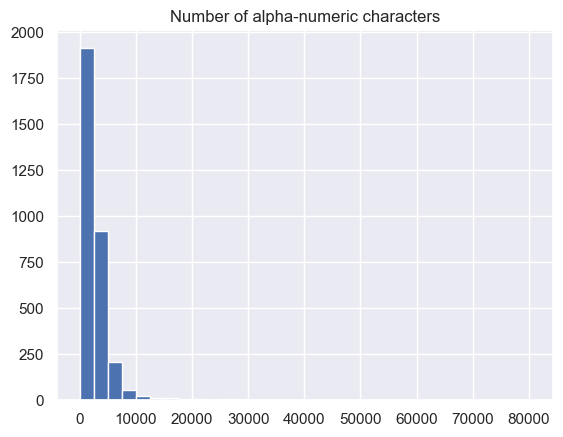

In [ ]:
alphanumeric_count = []

# Count number of alphanumeric characters
for text in df['full_text']:
    alphanumeric_count.append(len(re.sub(r'[^a-zA-Z0-9]','', text)))

plt.hist(alphanumeric_count, bins=32)
plt.title('Number of alpha-numeric characters')
plt.show()

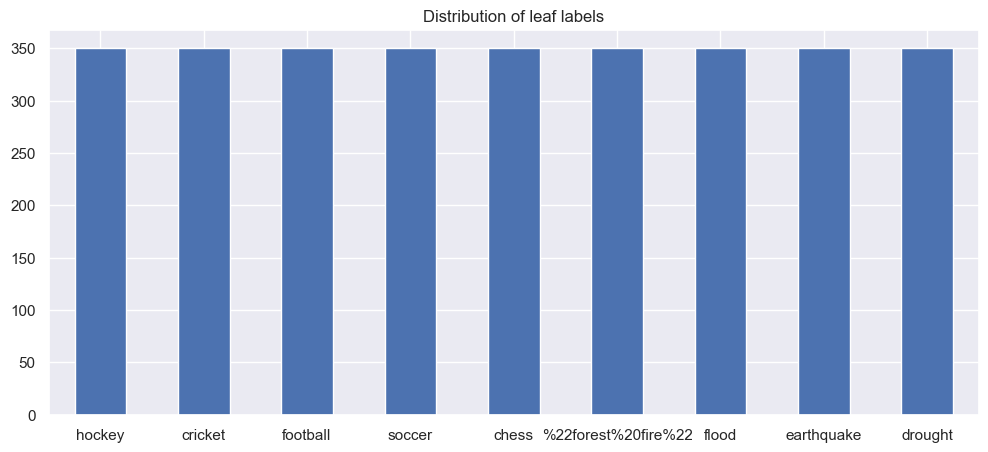

In [ ]:
pd.value_counts(df['leaf_label']).plot.bar(figsize=(12, 5), rot=0, title='Distribution of leaf labels')
plt.show()

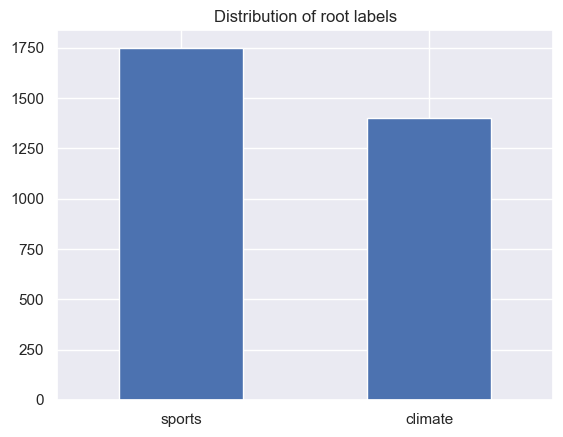

In [ ]:
pd.value_counts(df['root_label']).plot.bar(rot=0, title='Distribution of root labels')
plt.show()

## Binary Classification

### Splitting the entire dataset into training and testing data

In [ ]:
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

In [ ]:
print(train.shape)
print(test.shape)

(2520, 2)
(630, 2)


### Feature Extraction

In [ ]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns array of lowercased strings(words).
    wnl = nltk.wordnet.WordNetLemmatizer()
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
        for word, tag in nltk.pos_tag(nltk.word_tokenize(text))]

In [ ]:
def strip_punct_num(tokens):
    # Remove punctuations and numbers.
    punct = [word.translate(str.maketrans('', '', string.punctuation)) for word in tokens]
    return ' '.join(filter(lambda word: word.isalpha(), punct))

In [ ]:
def clean_lemmatize(text):
    # Wrapper for data cleaning, lemmatizing and final cleaning
    cleaned = clean(text)
    lemmatized = lemmatize_sent(cleaned)
    return strip_punct_num(lemmatized)

In [ ]:
train['full_text_clean'] = train['full_text'].apply(clean_lemmatize)
test['full_text_clean'] = test['full_text'].apply(clean_lemmatize)

In [ ]:
vectorizer = CountVectorizer(stop_words='english', min_df=3)
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(train['full_text_clean'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = vectorizer.transform(test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(2520, 14110)
(630, 14110)


### Dimensionality Reduction

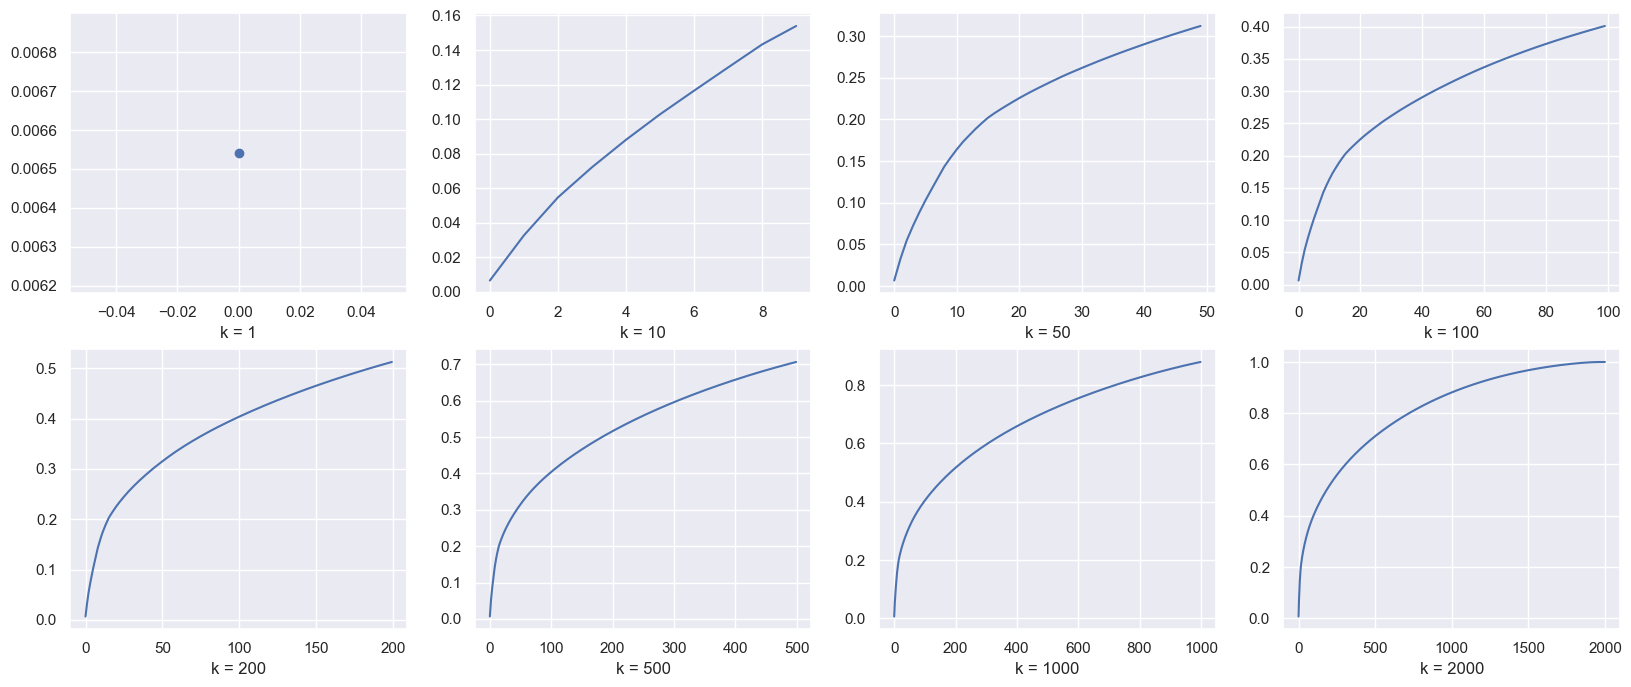

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

for i, k in enumerate([1, 10, 50, 100, 200, 500, 1000, 2000]):
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_train_tfidf_lsi = svd.fit_transform(X_train_tfidf)
    exp_var_ratio_cumsum = np.cumsum(svd.explained_variance_ratio_)
    
    curr_ax = ax[i // 4][i % 4]

    if i == 0:
        curr_ax.plot(range(len(exp_var_ratio_cumsum)), exp_var_ratio_cumsum, marker='o')
    else:
        curr_ax.plot(range(len(exp_var_ratio_cumsum)), exp_var_ratio_cumsum)

    curr_ax.set_xlabel(f'k = {k}')

plt.show()

In [ ]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_tfidf_lsi = svd.fit_transform(X_train_tfidf)

In [ ]:
nmf = NMF(n_components=50, random_state=42)
X_train_tfidf_nmf = nmf.fit_transform(X_train_tfidf)

In [ ]:
lsi_reconstruction_err = np.linalg.norm(svd.inverse_transform(X_train_tfidf_lsi) - X_train_tfidf.toarray())
print(f'Reconstruction residual MSE error:\nLSI: {lsi_reconstruction_err:.3f}\nNMF: {nmf.reconstruction_err_:.3f}')

Reconstruction residual MSE error:
LSI: 40.972
NMF: 41.268


## Classification Algorithm 

### Q5

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [ ]:
X_train, X_test = X_train_tfidf_lsi, svd.transform(X_test_tfidf)
y_train, y_test = train['root_label'], test['root_label']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
hard_svm = SVC(C=1000,random_state=42, probability=True)
soft_svm = SVC(C=0.0001,random_state=42, probability=True)

hard_svm_large_gamma = SVC(C=100000,random_state=42, probability=True)

In [ ]:
y_pred_hard = hard_svm.fit(X_train, y_train).predict(X_test) 
y_pred_soft = soft_svm.fit(X_train, y_train).predict(X_test)
y_pred_large_gamma = hard_svm_large_gamma.fit(X_train, y_train).predict(X_test)

In [ ]:
def plot_confusion_matrix(cm, classes, title):
    ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, cmap='Blues', annot=True, fmt='d')
    ax.set(xlabel='Predicted label', ylabel='True label', title=title)

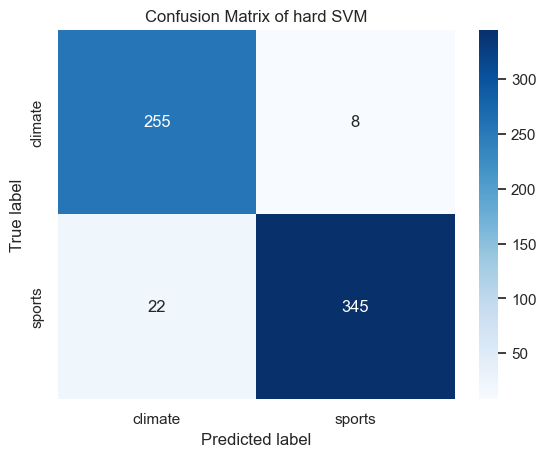

In [ ]:
hard_svm_cm = confusion_matrix(y_test, y_pred_hard)
plot_confusion_matrix(hard_svm_cm, classes=list(le.classes_), title='Confusion Matrix of hard SVM') 

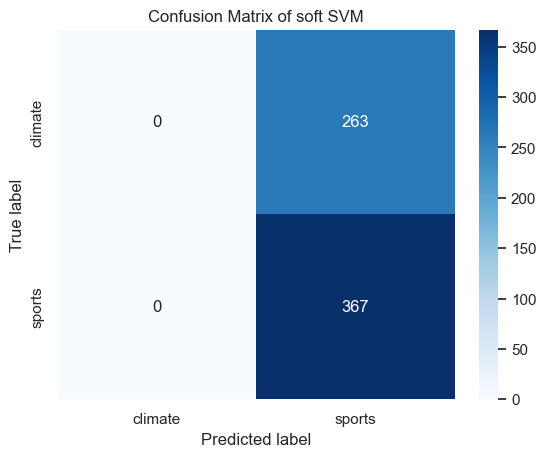

In [ ]:
soft_svm_cm = confusion_matrix(y_test, y_pred_soft)
plot_confusion_matrix(soft_svm_cm, classes=list(le.classes_), title='Confusion Matrix of soft SVM')

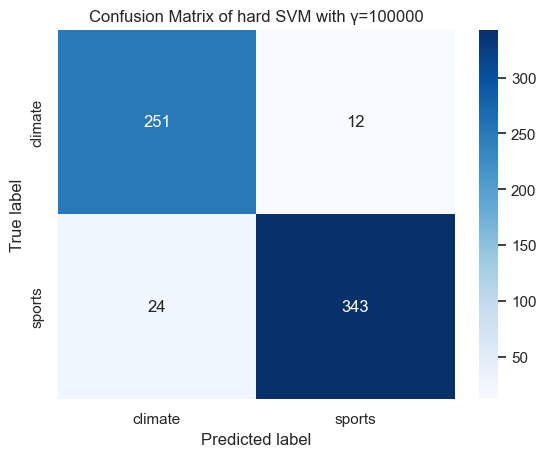

In [ ]:
large_gamma_cm = confusion_matrix(y_test, y_pred_large_gamma)
plot_confusion_matrix(large_gamma_cm, classes=list(le.classes_), title='Confusion Matrix of hard SVM with γ=100000')

In [ ]:
def calc_scores(y_true, y_pred, name, average='binary'):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average=average)
    pre = precision_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f'Scores for {name}:')
    print(f'\tAccuracy: \t{acc:.3f}')
    print(f'\tRecall: \t{rec:.3f}')
    print(f'\tPrecision: \t{pre:.3f}')
    print(f'\tF-1 score: \t{f1:.3f}')

In [ ]:
calc_scores(y_test, y_pred_hard, name='Hard SVM')
calc_scores(y_test, y_pred_soft, name='Soft SVM')
calc_scores(y_test, y_pred_large_gamma, name='Hard SVM with γ = 100000')

Scores for Hard SVM:
	Accuracy: 	0.952
	Recall: 	0.940
	Precision: 	0.977
	F-1 score: 	0.958
Scores for Soft SVM:
	Accuracy: 	0.583
	Recall: 	1.000
	Precision: 	0.583
	F-1 score: 	0.736
Scores for Hard SVM with γ = 100000:
	Accuracy: 	0.943
	Recall: 	0.935
	Precision: 	0.966
	F-1 score: 	0.950


In [ ]:
def plot_roc_curve(y_true, y_pred_proba, ax, name, color='tab:blue'):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve')
    ax.legend(loc='best')

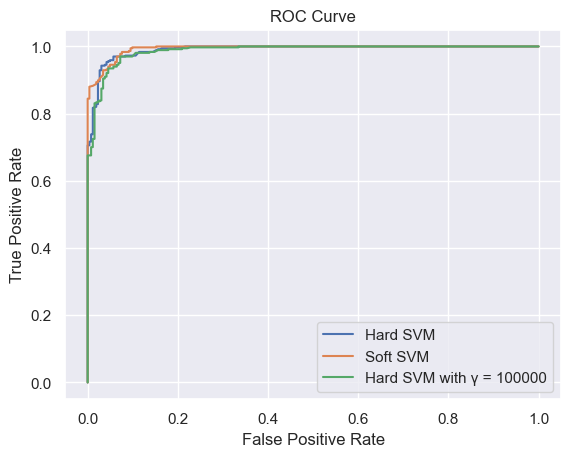

In [ ]:
fig, ax = plt.subplots()

y_pred_hard_proba = hard_svm.predict_proba(X_test)[:,1]
y_pred_soft_proba = soft_svm.predict_proba(X_test)[:,1]
y_pred_large_gamme_proba = hard_svm_large_gamma.predict_proba(X_test)[:,1]

plot_roc_curve(y_test, y_pred_hard_proba, ax, name='Hard SVM', color='tab:blue')
plot_roc_curve(y_test, y_pred_soft_proba, ax, name='Soft SVM', color='tab:green')
plot_roc_curve(y_test, y_pred_large_gamme_proba, ax, name='Hard SVM with γ = 100000', color='tab:orange')

In [ ]:
svc = SVC(random_state=42, probability=True) 
params = {'C':[10 ** k for k in range(-3, 7)]}
clf = GridSearchCV(svc, params, cv=5, scoring='accuracy') # Finding the best C using cross validation
grid_result = clf.fit(X_train, y_train)
print(f'Best acc: {grid_result.best_score_:.3f} with parameters: {clf.best_params_}')

Best acc: 0.959 with parameters: {'C': 10}


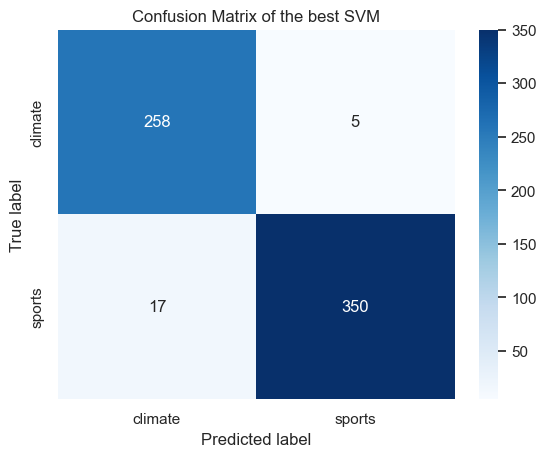

In [ ]:
y_pred_best = clf.predict(X_test)
best_cm = confusion_matrix(y_test, y_pred_best)
plot_confusion_matrix(best_cm, classes=list(le.classes_), title='Confusion Matrix of the best SVM')

In [ ]:
calc_scores(y_test, y_pred_hard, name='Best SVM')

Scores for Best SVM:
	Accuracy: 	0.952
	Recall: 	0.940
	Precision: 	0.977
	F-1 score: 	0.958


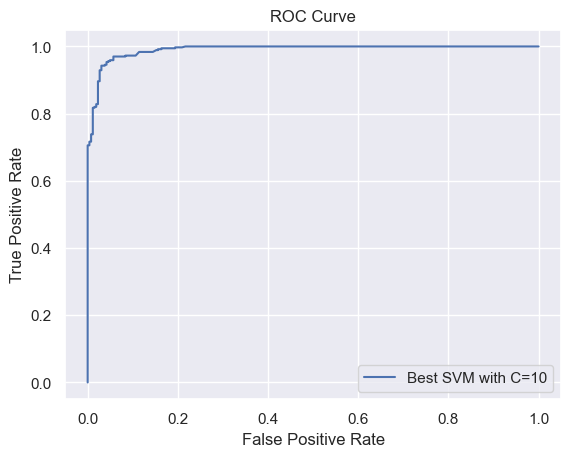

In [ ]:
fig, ax = plt.subplots()
y_pred_best_proba = clf.predict_proba(X_test)[:,1]
best_C = clf.best_params_['C']
plot_roc_curve(y_test, y_pred_hard_proba, ax, name=f'Best SVM with C={best_C}')

### Q6

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_raw = LogisticRegression(penalty='none', solver='newton-cg', random_state=42)
logistic_raw.fit(X_train, y_train)
y_pred_logistic_raw = logistic_raw.predict(X_test)

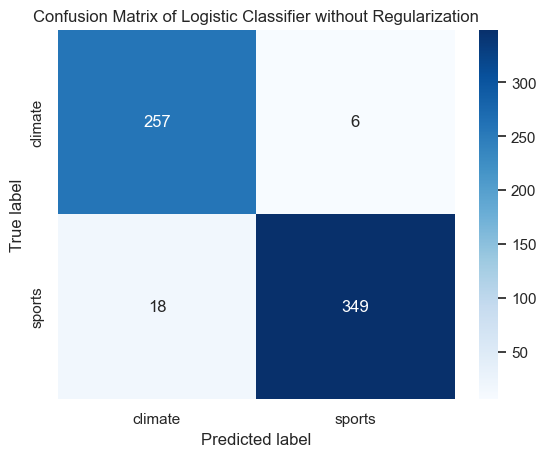

In [ ]:
logistic_raw_cm = confusion_matrix(y_test, y_pred_logistic_raw)
plot_confusion_matrix(logistic_raw_cm, classes=list(le.classes_), title='Confusion Matrix of Logistic Classifier without Regularization') 

In [ ]:
calc_scores(y_test, y_pred_logistic_raw, name='Logistic Classifier without Regularization')

Scores for Logistic Classifier without Regularization:
	Accuracy: 	0.962
	Recall: 	0.951
	Precision: 	0.983
	F-1 score: 	0.967


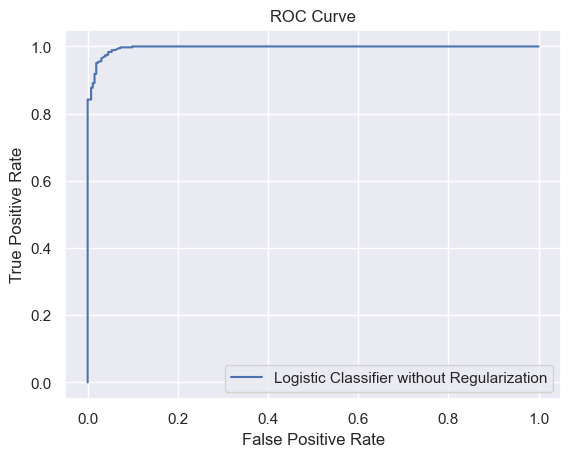

In [ ]:
fig, ax = plt.subplots()
y_pred_logistic_raw_proba = logistic_raw.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, y_pred_logistic_raw_proba, ax, name=f'Logistic Classifier without Regularization')

In [ ]:
logi = LogisticRegression(penalty='l1', solver='liblinear', random_state=42) 
params = {'C':[10 ** k for k in range(-5, 6)]}
logi_l1_clf = GridSearchCV(logi, params, cv=5, scoring='accuracy') # Finding the best C using cross validation
grid_result = logi_l1_clf.fit(X_train, y_train)
print(f'Best acc: {grid_result.best_score_:.3f} with parameters: {logi_l1_clf.best_params_}')

Best acc: 0.953 with parameters: {'C': 1000}


In [ ]:
logi = LogisticRegression(penalty='l2', solver='liblinear', random_state=42) 
params = {'C':[10 ** k for k in range(-5, 6)]}
logi_l2_clf = GridSearchCV(logi, params, cv=5, scoring='accuracy') # Finding the best C using cross validation
grid_result = logi_l2_clf.fit(X_train, y_train)
print(f'Best acc: {grid_result.best_score_:.3f} with parameters: {logi_l2_clf.best_params_}')

Best acc: 0.953 with parameters: {'C': 1000}


In [ ]:
y_pred_l1 = logi_l1_clf.predict(X_test)
y_pred_l2 = logi_l2_clf.predict(X_test)

In [ ]:
calc_scores(y_test, y_pred_logistic_raw, name='Logistic Classifier without Regularization')
calc_scores(y_test, y_pred_l1, name='Logistic Classifier with l1 Regularization')
calc_scores(y_test, y_pred_l2, name='Logistic Classifier with l2 Regularization')

Scores for Logistic Classifier without Regularization:
	Accuracy: 	0.962
	Recall: 	0.951
	Precision: 	0.983
	F-1 score: 	0.967
Scores for Logistic Classifier with l1 Regularization:
	Accuracy: 	0.962
	Recall: 	0.951
	Precision: 	0.983
	F-1 score: 	0.967
Scores for Logistic Classifier with l2 Regularization:
	Accuracy: 	0.962
	Recall: 	0.948
	Precision: 	0.986
	F-1 score: 	0.967


### Q7

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_gaussian = gaussian.predict(X_test)

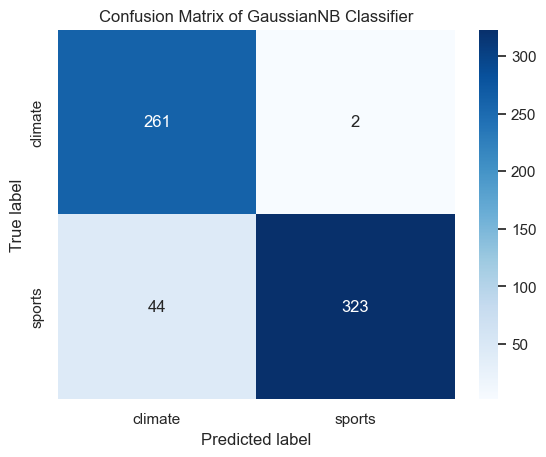

In [ ]:
gaussian_cm = confusion_matrix(y_test, y_pred_gaussian)
plot_confusion_matrix(gaussian_cm, classes=list(le.classes_), title='Confusion Matrix of GaussianNB Classifier') 

In [ ]:
calc_scores(y_test, y_pred_gaussian, name='GaussianNB Classifier')

Scores for GaussianNB Classifier:
	Accuracy: 	0.927
	Recall: 	0.880
	Precision: 	0.994
	F-1 score: 	0.934


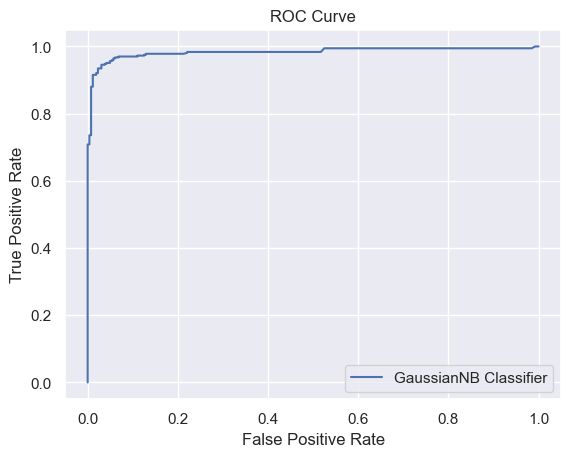

In [ ]:
fig, ax = plt.subplots()
y_pred_gaussian = gaussian.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, y_pred_gaussian, ax, name=f'GaussianNB Classifier')

## Pipeline Construction

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

### Data cleaning

In [ ]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(clean)

### Feature Extraction

In [ ]:
class Lemmatizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.lemmatize)
    
    def lemmatize(self, text):
        return strip_punct_num(lemmatize_sent(text))

In [ ]:
class Stemmer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.stem)
    
    def stem(self, text):
        ps = nltk.stem.PorterStemmer()
        words = nltk.tokenize.word_tokenize(text)
        result = []
        for w in words:
            result.append(ps.stem(w))
        return strip_punct_num(result)

### Build the pipeline and perform GridSearchCV

In [ ]:
pipe = Pipeline(
    steps=[
        ('cleaner', DataCleaner()),
        ('compressor', None),
        ('counter', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduction', None),
        ('clf', None)
    ]
)

In [ ]:
X_train_raw, X_test_raw = train.full_text, test.full_text
y_train_raw, y_test_raw = train.root_label, test.root_label

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_raw)
y_test_encoded = le.transform(y_test_raw)

In [ ]:
params_grid = [
    {
        'compressor': [Lemmatizer(), Stemmer()],
        'counter__min_df': [3, 5],
        'reduction': [TruncatedSVD(random_state=42), NMF(random_state=42)],
        'reduction__n_components': [5, 30, 80],
        'clf': [
            SVC(random_state=42, probability=True, C=10),
            LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=1000),
            LogisticRegression(penalty='l2', solver='liblinear', random_state=42, C=1000),
            GaussianNB()
        ]
    }
]

gs = GridSearchCV(pipe, params_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train_raw, y_train_encoded)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner', DataCleaner()),
                                       ('compressor', None),
                                       ('counter',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduction', None), ('clf', None)]),
             n_jobs=-1,
             param_grid=[{'clf': [SVC(C=10, probability=True, random_state=42),
                                  LogisticRegression(C=1000, penalty='l1',
                                                     random_state=42,
                                                     solver='liblinear'),
                                  LogisticRegression(C=1000, random_state=42,
                                                     solver='liblinear'),
                                  GaussianNB()],
                          'compressor': [Lemmatizer(), Stemmer()],
                          'counter__min_df': [3, 5],
                          'reduction': [TruncatedSVD(n_components=80,
                                                     random_state=42),
                                        NMF(random_state=42)],
                          'reduction__n_components': [5, 30, 80]}],
             scoring='accuracy')

In [ ]:
results_df = pd.DataFrame(gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head()

,params,rank_test_score,mean_test_score,std_test_score
14,"{'clf': SVC(C=10, probability=True, random_sta...",1,0.961905,0.008640
20,"{'clf': SVC(C=10, probability=True, random_sta...",2,0.961508,0.008190
8,"{'clf': SVC(C=10, probability=True, random_sta...",3,0.960714,0.011040
2,"{'clf': SVC(C=10, probability=True, random_sta...",4,0.960317,0.010348
56,"{'clf': LogisticRegression(C=1000, random_stat...",5,0.959921,0.013125


In [ ]:
for p in list(results_df.params.head()):
    print(p)

{'clf': SVC(C=10, probability=True, random_state=42), 'compressor': Stemmer(), 'counter__min_df': 3, 'reduction': TruncatedSVD(n_components=80, random_state=42), 'reduction__n_components': 80}
{'clf': SVC(C=10, probability=True, random_state=42), 'compressor': Stemmer(), 'counter__min_df': 5, 'reduction': TruncatedSVD(n_components=80, random_state=42), 'reduction__n_components': 80}
{'clf': SVC(C=10, probability=True, random_state=42), 'compressor': Lemmatizer(), 'counter__min_df': 5, 'reduction': TruncatedSVD(n_components=80, random_state=42), 'reduction__n_components': 80}
{'clf': SVC(C=10, probability=True, random_state=42), 'compressor': Lemmatizer(), 'counter__min_df': 3, 'reduction': TruncatedSVD(n_components=80, random_state=42), 'reduction__n_components': 80}
{'clf': LogisticRegression(C=1000, random_state=42, solver='liblinear'), 'compressor': Lemmatizer(), 'counter__min_df': 5, 'reduction': TruncatedSVD(n_components=80, random_state=42), 'reduction__n_components': 80}


### Q9

### Prepare data for multiclass classification

In [ ]:
train, test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)

train['full_text_clean'] = train['full_text'].apply(clean_lemmatize)
test['full_text_clean'] = test['full_text'].apply(clean_lemmatize)

vectorizer = CountVectorizer(stop_words='english', min_df=3)
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(train['full_text_clean'])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = vectorizer.transform(test['full_text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

svd = TruncatedSVD(n_components=50, random_state=42)
X_train = svd.fit_transform(X_train_tfidf)

X_test = svd.transform(X_test_tfidf)
y_train, y_test = train['leaf_label'], test['leaf_label']

In [ ]:
custom_order = {"chess": 0, "cricket": 1, "hockey": 2, "soccer": 3, "football": 4, "%22forest%20fire%22": 5, "flood": 6, "earthquake": 7, "drought": 8}
y_train = y_train.apply(lambda x: custom_order[x])
y_test = y_test.apply(lambda x: custom_order[x])

### Train a Naive Bayes classifier

In [ ]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_gaussian = gaussian.predict(X_test)

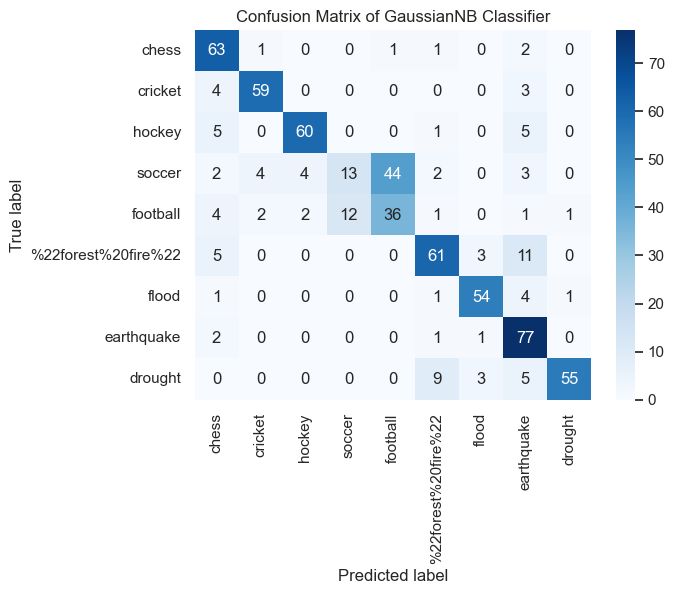

In [ ]:
gaussian_cm = confusion_matrix(y_test, y_pred_gaussian)
plot_confusion_matrix(gaussian_cm, classes=custom_order.keys(), title='Confusion Matrix of GaussianNB Classifier') 

In [ ]:
calc_scores(y_test, y_pred_gaussian, name='GaussianNB Classifier', average='weighted')

Scores for GaussianNB Classifier:
	Accuracy: 	0.759
	Recall: 	0.759
	Precision: 	0.762
	F-1 score: 	0.744


### Train a One-vs-One SVM and a One-vs-Rest SVM

In [ ]:
ovo_svm = SVC(random_state=42, C=10)    # Multiclass is handled as One-vs-One
ovr_svm = LinearSVC(random_state=42, C=10, multi_class='ovr')

y_pred_ovo = ovo_svm.fit(X_train, y_train).predict(X_test)
y_pred_ovr = ovr_svm.fit(X_train, y_train).predict(X_test)

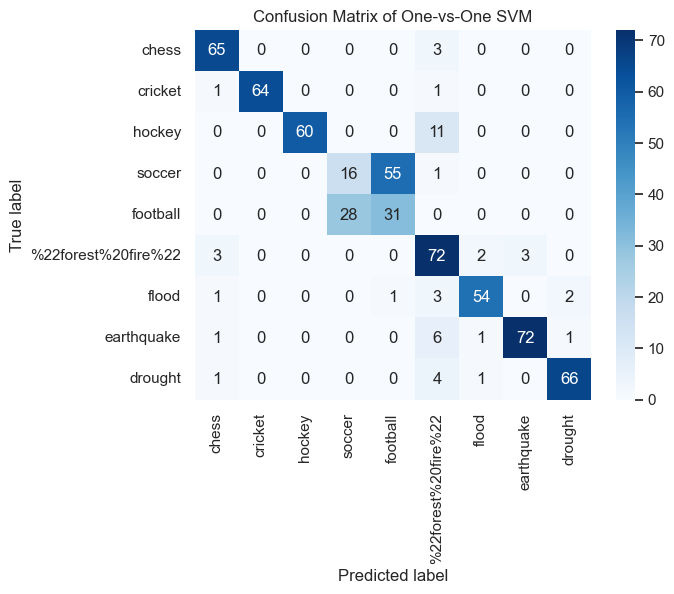

In [ ]:
ovo_cm = confusion_matrix(y_test, y_pred_ovo)
plot_confusion_matrix(ovo_cm, classes=custom_order.keys(), title='Confusion Matrix of One-vs-One SVM') 

In [ ]:
calc_scores(y_test, y_pred_ovo, name='One-vs-One SVM', average='weighted')

Scores for One-vs-One SVM:
	Accuracy: 	0.794
	Recall: 	0.794
	Precision: 	0.803
	F-1 score: 	0.792


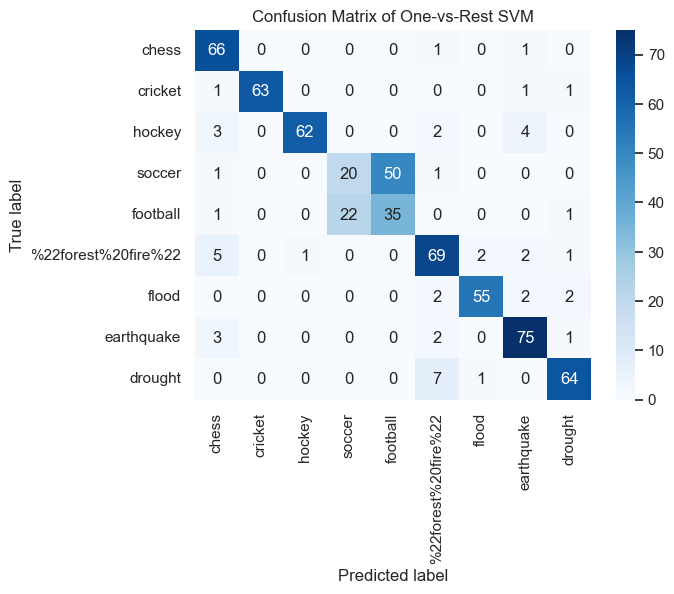

In [ ]:
ovr_cm = confusion_matrix(y_test, y_pred_ovr)
plot_confusion_matrix(ovr_cm, classes=custom_order.keys(), title='Confusion Matrix of One-vs-Rest SVM') 

In [ ]:
calc_scores(y_test, y_pred_ovr, name='One-vs-Rest SVM', average='weighted')

Scores for One-vs-Rest SVM:
	Accuracy: 	0.808
	Recall: 	0.808
	Precision: 	0.812
	F-1 score: 	0.804


### Merge soccer and football

In [ ]:
y_train, y_test = train['leaf_label'], test['leaf_label']

y_train_merged = y_train.replace('soccer', 'football')
y_test_merged = y_test.replace('soccer', 'football')

custom_order = {"chess": 0, "cricket": 1, "hockey": 2, "football": 3, "%22forest%20fire%22": 4, "flood": 5, "earthquake": 6, "drought": 7}
y_train_merged = y_train_merged.apply(lambda x: custom_order[x])
y_test_merged = y_test_merged.apply(lambda x: custom_order[x])

In [ ]:
ovo_svm = SVC(random_state=42, C=10)    # Multiclass is handled as One-vs-One
ovr_svm = LinearSVC(random_state=42, C=10, multi_class='ovr')

y_pred_ovo_merged = ovo_svm.fit(X_train, y_train_merged).predict(X_test)
y_pred_ovr_merged = ovr_svm.fit(X_train, y_train_merged).predict(X_test)

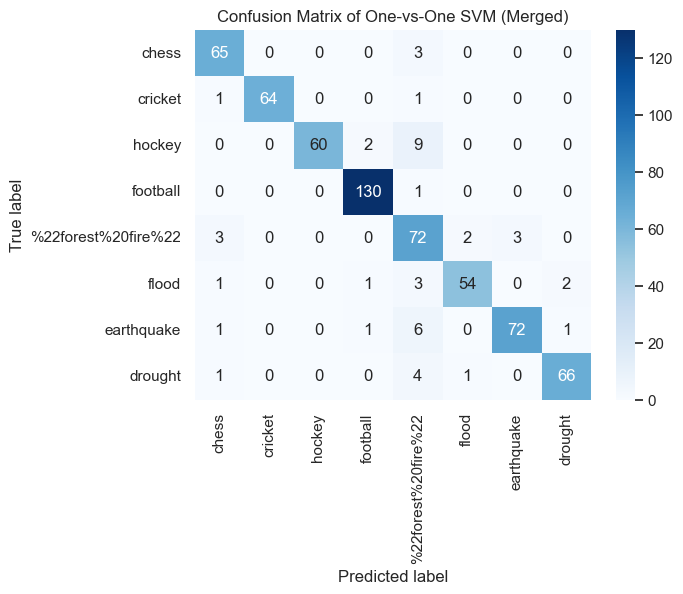

In [ ]:
ovo_merged_cm = confusion_matrix(y_test_merged, y_pred_ovo_merged)
plot_confusion_matrix(ovo_merged_cm, classes=custom_order.keys(), title='Confusion Matrix of One-vs-One SVM (Merged)') 

In [ ]:
print(f'Accuracy score for One-vs-One SVM (Merged): \t{accuracy_score(y_test_merged, y_pred_ovo_merged):.3f}')

Accuracy score for One-vs-One SVM (Merged): 	0.925


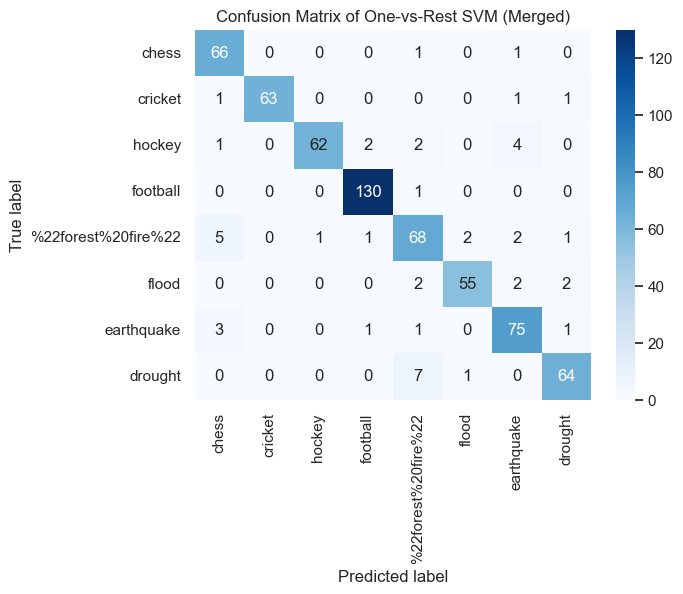

In [ ]:
ovr_merged_cm = confusion_matrix(y_test_merged, y_pred_ovr_merged)
plot_confusion_matrix(ovr_merged_cm, classes=custom_order.keys(), title='Confusion Matrix of One-vs-Rest SVM (Merged)') 

In [ ]:
print(f'Accuracy score for One-vs-Rest SVM (Merged): \t{accuracy_score(y_test_merged, y_pred_ovr_merged):.3f}')

Accuracy score for One-vs-Rest SVM (Merged): 	0.925


### Drop some data with label football

In [ ]:
football_index = np.argwhere(y_train_merged.to_numpy() == custom_order['football']).flatten()
drop_index = np.random.choice(football_index, len(football_index) // 2, replace=False)
X_train_dropped = np.delete(X_train, drop_index, axis=0)
y_train_dropped = np.delete(y_train_merged.to_numpy(), drop_index, axis=0)

In [ ]:
ovo_svm = SVC(random_state=42, C=10)    # Multiclass is handled as One-vs-One
ovr_svm = LinearSVC(random_state=42, C=10, multi_class='ovr')

y_pred_ovo_dropped = ovo_svm.fit(X_train_dropped, y_train_dropped).predict(X_test)
y_pred_ovr_dropped = ovr_svm.fit(X_train_dropped, y_train_dropped).predict(X_test)

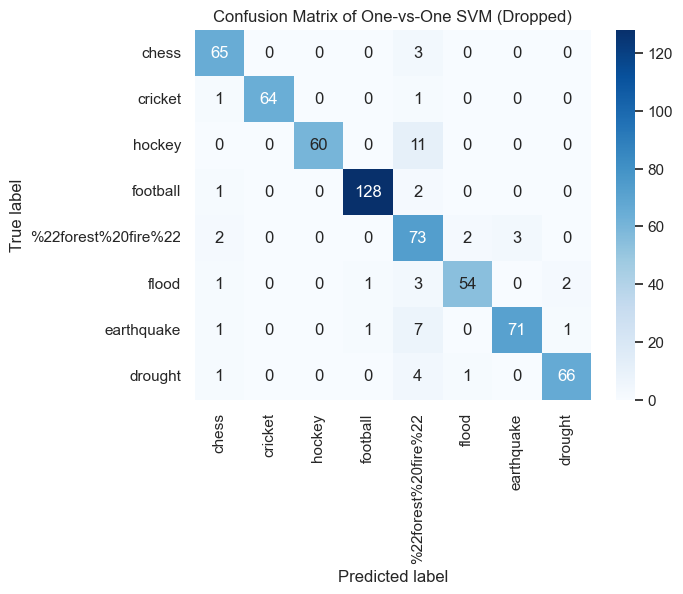

In [ ]:
ovo_dropped_cm = confusion_matrix(y_test_merged, y_pred_ovo_dropped)
plot_confusion_matrix(ovo_dropped_cm, classes=custom_order.keys(), title='Confusion Matrix of One-vs-One SVM (Dropped)') 

In [ ]:
print(f'Accuracy score for One-vs-One SVM (Dropped): \t{accuracy_score(y_test_merged, y_pred_ovo_dropped):.3f}')

Accuracy score for One-vs-One SVM (Dropped): 	0.922


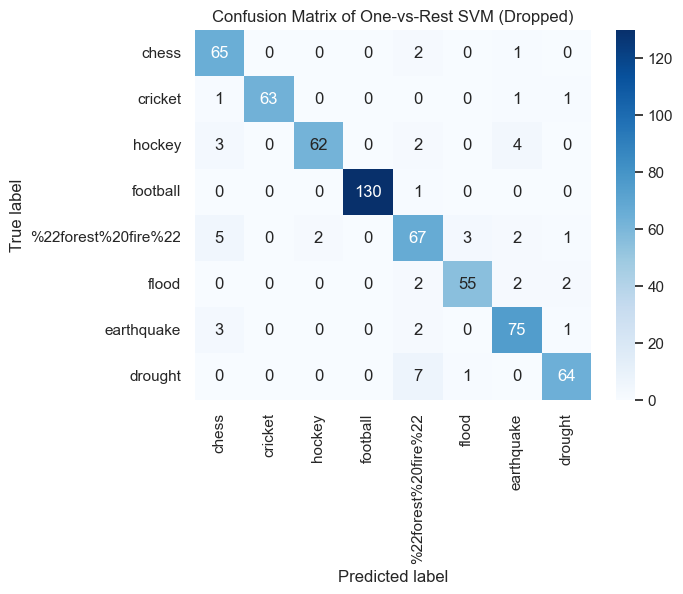

In [ ]:
ovr_dropped_cm = confusion_matrix(y_test_merged, y_pred_ovr_dropped)
plot_confusion_matrix(ovr_dropped_cm, classes=custom_order.keys(), title='Confusion Matrix of One-vs-Rest SVM (Dropped)') 

In [ ]:
print(f'Accuracy score for One-vs-Rest SVM (Dropped): \t{accuracy_score(y_test_merged, y_pred_ovr_dropped):.3f}')

Accuracy score for One-vs-Rest SVM (Dropped): 	0.922


## Word Embedding

In [ ]:
from scipy import spatial
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [ ]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

### Q11(a)

In [ ]:
def tokenize(text):
    return word_tokenize(text)

In [ ]:
# Tokenize the data frame into individual words

df['full_text_clean'] = df['full_text'].apply(clean_lemmatize)
#df['full_text_tokens'] = df['full_text_clean'].apply(tokenize)

df['keywords_clean'] = df['keywords'].apply(clean_lemmatize)
#df['keywords_tokens'] = df['keywords_clean'].apply(tokenize)

In [ ]:
# Average the embedding vectors for all words 
# to obtain a single feature vector representing the entire document.

feature_vectors = []

for i, row in df.iterrows():

    # Tokenize the text column
    tokens = row['full_text_clean'].split()

    # Iterate over the tokens
    word_vectors = []
    # Look up the GLoVE embedding vector for each word in the text
    for word in tokens:
        vec = embeddings_dict.get(word)
        if vec is not None:
            word_vectors.append(vec)

    # Average the word vectors
    if word_vectors:
        feature_vector = np.mean(word_vectors, axis=0)
    else:
        feature_vector = np.zeros(300)

    # Append the feature vector to the list
    feature_vectors.append(feature_vector)

# Create a new column in the dataframe to store the feature vectors
df['feature_vector'] = feature_vectors

In [ ]:
# Normalize the feature vector by dividing each element by the vector's L2-norm.
df['normal_feature_vector'] = df['feature_vector'].apply(lambda x: x/np.linalg.norm(x))

### Q11(b)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Define the feature matrix and target vector for the training set
X_train = train_df['normal_feature_vector'].tolist()
y_train = train_df['root_label'].tolist()

# Define the feature matrix and target vector for the test set
X_test = test_df['normal_feature_vector'].tolist()
y_test = test_df['root_label'].tolist()

In [ ]:
# Create an instance of the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,pos_label='climate')
recall = recall_score(y_test, y_pred,pos_label='climate')
f1 = f1_score(y_test, y_pred,pos_label='climate')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

### Q12

In [ ]:
def load_glove_embeddings(filepath):
  embeddings_dict = {}
  with open(filepath, 'r') as f:
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], dtype='float32')
          embeddings_dict[word] = vector
  return embeddings_dict

In [ ]:
def load_glove_embeddings(filepath):
  embeddings_dict = {}
  with open(filepath, 'r') as f:
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], dtype='float32')
          embeddings_dict[word] = vector
  return embeddings_dict

In [ ]:
# Plot the relationship between dimension and accuracy
plt.scatter(dims, accuracies)
plt.xlabel('Dimension of GLoVE embedding')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
!pip install umap
!pip install umap-learn
import umap
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler

In [ ]:
# Initialize the UMAP model
umap_model = umap.umap_.UMAP()

# Fit the UMAP model to the feature vectors
l = []
for i in df["normal_feature_vector_300"]:
  l.append(list(i))
embeddings = umap_model.fit_transform(l)

# Add the embeddings and labels to the dataframe
df['umap_x'] = embeddings[:, 0]
df['umap_y'] = embeddings[:, 1]

In [ ]:
# Visualize the embeddings with the labels using a scatter plot
label = []
for i in range(len(df["root_label"])):
  if df["root_label"][i]=="sports":
    label.append(1)
  else:
    label.append(2)
df["num_label"] = label

plt.scatter(df['umap_x'], df['umap_y'],c=df['num_label'], cmap='rainbow')
plt.title("Normalized GLoVE-based Embeddings")
plt.show()

In [ ]:
# Generate a set of normalized random vectors
random_vectors = np.random.randn(df.shape[0], 300)
random_vectors = random_vectors / np.linalg.norm(random_vectors, axis=1, keepdims=True)

# Fit the UMAP model to the random vectors
random_embeddings = umap_model.fit_transform(random_vectors)

# Visualize the random embeddings with the labels using a scatter plot
plt.scatter(random_embeddings[:, 0], random_embeddings[:, 1], c=df['num_label'], cmap='rainbow')
plt.title("Normalized Random Vectors")
plt.show()